# Pre set for the analysis environment

In [45]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve

# Model fitting
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# XGB
import xgboost as xgb


# file name
file = '/content/drive/My Drive/Colab Notebooks/Kaggle/credit card fraud/creditcard.csv'

# Data Preparation Process

## load the data

In [47]:
data = pd.read_csv(file)
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Summary of all variables

In [0]:
print('Number of observations: ',len(data),'. Number of Columns: ',len(data.columns))
data.describe()

Number of observations:  284807 . Number of Columns:  31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Check the missing values

In [0]:
data.isnull().sum().max() # Which means that no missing values in all columns

0

## Distributions of the 'time', 'amount', and 'class' variables

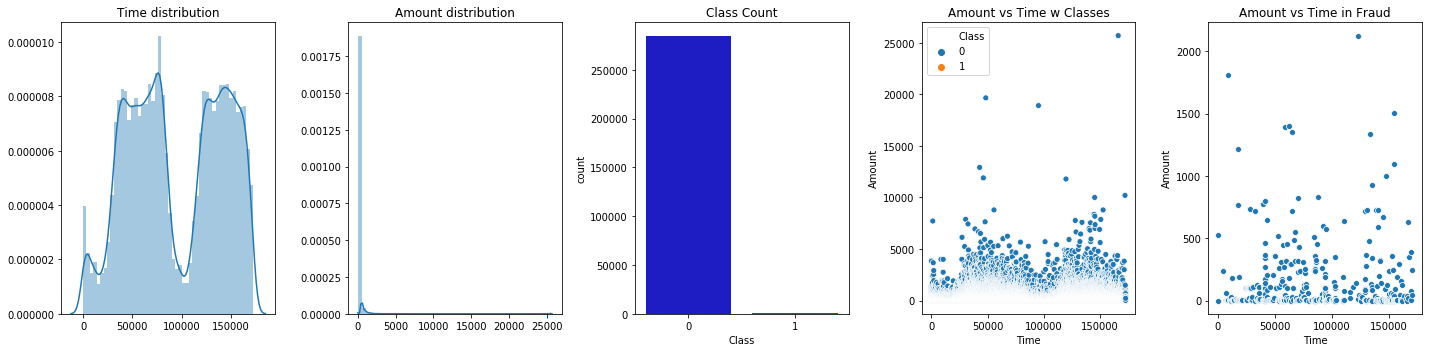

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(20,5))
sns.distplot(data['Time'].values,ax=axes[0])
axes[0].title.set_text('Time distribution')
sns.distplot(data['Amount'].values,ax=axes[1])
axes[1].title.set_text('Amount distribution')
sns.countplot('Class', data=data, ax=axes[2], palette = ["#0101DF", "#DF0101"])
axes[2].title.set_text('Class Count')
sns.scatterplot(x='Time', y='Amount', hue='Class', data=data, ax=axes[3])
axes[3].title.set_text('Amount vs Time w Classes')
sns.scatterplot(x='Time', y='Amount', data=data.loc[data['Class']==1], ax=axes[4])
axes[4].title.set_text('Amount vs Time in Fraud')
fig.tight_layout()

In [0]:
print('Class 0: ',len(data.loc[data['Class']==0])/len(data)*100,'%, Class 1: ',len(data.loc[data['Class']==1])/len(data)*100,'%')

Class 0:  99.82725143693798 %, Class 1:  0.1727485630620034 %


We would notice two things:

1. Almost 99.9% of the records are normal and only 0.17% records are fruad. This is an extremely inbalanced dataset.

2. Many Fraud records only have a very small amount of money. There is no simple and direct relation between time, amount and the fraud.

## Check out with other pre-PCA variables

Because of the data privacy, the information of the real variables are not provided. The only provided variables are the PCA transformation with the reduced dimension. We could start with the visualization of the first two components. Additionally, a t-sne visualization could be used to display the condensed information of all principle components.

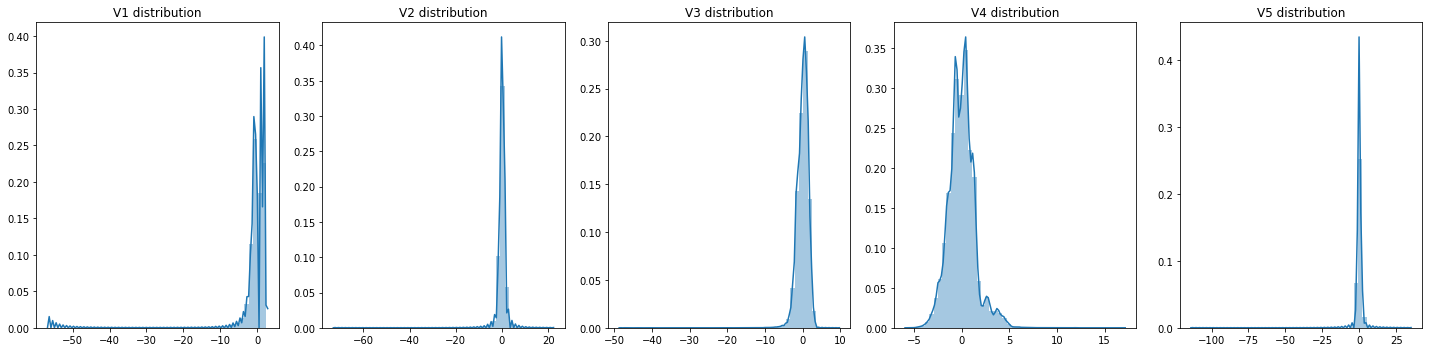

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(20,5))
sns.distplot(data['V1'].values,ax=axes[0])
axes[0].title.set_text('V1 distribution')
sns.distplot(data['V2'].values,ax=axes[1])
axes[1].title.set_text('V2 distribution')
sns.distplot(data['V3'].values,ax=axes[2])
axes[2].title.set_text('V3 distribution')
sns.distplot(data['V4'].values,ax=axes[3])
axes[3].title.set_text('V4 distribution')
sns.distplot(data['V5'].values,ax=axes[4])
axes[4].title.set_text('V5 distribution')
fig.tight_layout()

Visualize the first three principle components.

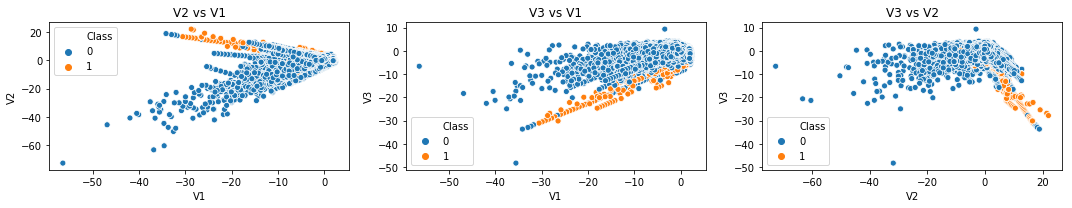

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,3))
sns.scatterplot(x='V1', y='V2', hue = 'Class', data=data, ax = axes[0])
axes[0].title.set_text('V2 vs V1')
sns.scatterplot(x='V1', y='V3', hue = 'Class', data=data, ax = axes[1])
axes[1].title.set_text('V3 vs V1')
sns.scatterplot(x='V2', y='V3', hue = 'Class', data=data, ax = axes[2])
axes[2].title.set_text('V3 vs V2')
fig.tight_layout()

There are examples that people do a further PCA on the principle components. However, I don't think it would give more senses because the principle components have already been orthonormaled as much as possible. However, we could try LDA to do a further projections of the data and check if the two classes are more seperable.

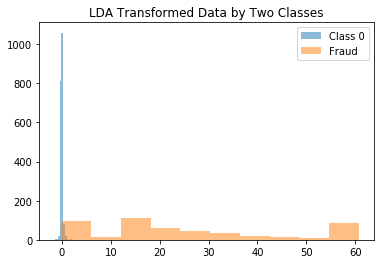

In [0]:
# Standardize time and amount
X = data.iloc[:,0:30].values
y = data.iloc[:,30].values
sc = StandardScaler()
X = sc.fit_transform(X)

# Perform LDA
lda = LDA(n_components=1)
X = lda.fit_transform(X, y)

# Visualize LDA by randomly chosen 2000 obs in class 0 and all obs in class 1
plt.hist(X[np.where(y==0)[0]][np.random.randint(0, len(X[np.where(y==0)[0]]), size=2000)], alpha=0.5, label='Class 0')
plt.hist(X[np.where(y==1)[0]], alpha=0.5, label='Fraud')
plt.title('LDA Transformed Data by Two Classes')
plt.legend(loc='upper right')
plt.show()

Here I did a very rough LDA on the whole dataset, which means that I did not seperate the training and testing dataset. I just used the whole dataset (definitely bring the overfitting problem). One point I want to make is that the super imbalanced dataset is definitely hard for traditional classification methods. Here the class 0 with lots of data gather very close to each other, but the Fraud class data spreads a lot. Especially at the boundary, it is very difficult to seperate the two classes.

Visualization by T-sne

Text(0.5, 1.0, 't-SNE')

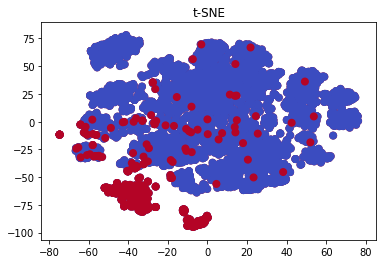

In [0]:
# Standardize time and amount
dat_nofraud = data.values[np.where(data.values[:,30]==0),:][0]
dat_fraud = data.values[np.where(data.values[:,30]==1),:][0]
idxs = np.random.randint(0, len(dat_nofraud), size=5000)
X = np.concatenate([dat_nofraud[idxs,0:30],dat_fraud[:,0:30]])
Y = np.concatenate([dat_nofraud[idxs,30],dat_fraud[:,30]])
sc = StandardScaler()
X = sc.fit_transform(X)

# T-SNE transformation
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(X)

# t-SNE scatter plot
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(Y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=(Y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE')

Using all the data for tsne will cost too much. Here a random sample (5000 obs) of non-fraud records is selected and combined with all the fraud records (492 obs). As a result, 5492 records in total are used in the tsne. We could see that two classes are seperated in general. However, still many fraud records cannot be seperated from the non-fraud records. In real life, the fraud happens rarely but if it happens, it will cost a great loss. We should make the classification much more precisely. So now, we should start with some model fitting. We need to deal with the imbalanced data and try to have a more legit prediction model.

# Model Fitting

The trainning set and testing set split here would be a bit different from we usually do. Because of the highly imbalanced ratio, the test set we want should still maintain the ratio of the data in two classes. To do that, we could use the stratified split to seperate the data.

To evaluate the imbalanced data in the classification task, the accuracy would not make much sense because if our model simply classify every thing to non-fraud, the accuracy could go up to 99%. The evaluation metrics we want should contain:

**Confusion Matrix**: a table showing correct predictions and types of incorrect predictions.

**Precision**: the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

**Recall**: the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

**F1**: Score: the weighted average of precision and recall.

And also the ROC scores and plot.

In [48]:
X = data.drop('Class', axis=1)
y = data['Class']

# Stratified K fold
sts = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)

# Train and test data set
for train_idx,test_idx in sts.split(X,y):
  X_train,X_test = X.iloc[train_idx],X.iloc[test_idx]
  y_train,y_test = y.iloc[train_idx],y.iloc[test_idx]
  
# Make sure the ratio is still the same
print('Train: Class 0: ',len(np.where(y_train.values==0)[0])/len(y_train)*100,
      '%, Class 1: ',len(np.where(y_train.values==1)[0])/len(y_train)*100,'%')
print('Test: Class 0: ',len(np.where(y_test.values==0)[0])/len(y_test)*100,
      '%, Class 1: ',len(np.where(y_test.values==1)[0])/len(y_test)*100,'%')

# Standardize the data values
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test = sc.fit_transform(X_test.values)

Train: Class 0:  99.82745129511848 %, Class 1:  0.17254870488152324 %
Test: Class 0:  99.8267851082008 %, Class 1:  0.17321489179921118 %


## Applying Resampling Techniques for Classification

In general, there are two resampling techniques dealing with the imbalanced dataset, **Oversampling** the minority class and **Undersampling** the majority class. These two techniques help the proportion of all groups in the training data closer to each other.

**Oversampling** the minority class can be done by simple repetition, bootstrap or even more advanced design like **SMOTE** (synthetic minority over-sampling technique). I will try the repetition sampling with a small random noise add into the data.

**Undersampling** the majority class can be done by just sampling a subset of the original larger group. However, this would definitely cause the infromation loss. Directly using one sample of the majority class will not be proper, we could use the random forest idea that keep sampling and fit the model and average the result at the end. This could be an idea for those who want to be innovative when doing the model fitting but I will not do it here.

In [0]:
## Oversampling data preparation
# get random noise prepared. Since the data normalized already, we just sample noise from standard norm
rand_noise = np.random.normal(size=X_train[np.where(y_train==0)[0]].shape)

# Upsample the minority group
from sklearn.utils import resample
fraud_upsampled = resample(X_train[np.where(y_train==1)[0]],
                          replace=True, # sample with replacement
                          n_samples=len(rand_noise), # match number in majority class
                          random_state=1) # reproducible results
fraud_upsampled = fraud_upsampled + rand_noise # add the random noise

# Combine the upsampled data and the non-fraud training data
X_train_upsamp = np.concatenate([X_train[np.where(y_train==0)[0]],fraud_upsampled])
y_train_upsamp = np.concatenate([np.zeros(len(X_train[np.where(y_train==0)[0]])),np.ones(len(fraud_upsampled))])

print('Training data size after oversampling: ',len(y_train_upsamp))

Training data size after oversampling:  398040


In [0]:
## Model Fitting
# Logistic Regression
Logistic_upsamp = LogisticRegression(solver='liblinear').fit(X_train_upsamp, y_train_upsamp)
Logistic_upsamp_pred = Logistic_upsamp.predict(X_test)

## Model Evaluation
print(classification_report(y_test, Logistic_upsamp_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.91      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [0]:
## My laptop computing power is limited, cannot run SVM for all the data
# SVM
svm_upsamp = SVC(gamma='auto',kernel='linear').fit(X_train_upsamp, y_train_upsamp)
svm_upsamp_pred = svm_upsamp.predict(X_test)

## Model Evaluation
print(classification_report(y_test, svm_upsamp_pred))

In [0]:
# Random Forest
rfc_upsamp = RandomForestClassifier(n_estimators=5).fit(X_train_upsamp, y_train_upsamp)
rfc_upsamp_pred = rfc_upsamp.predict(X_test)

## Model Evaluation
print(classification_report(y_test, rfc_upsamp_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.16      0.87      0.26       148

    accuracy                           0.99     85443
   macro avg       0.58      0.93      0.63     85443
weighted avg       1.00      0.99      0.99     85443



Though Above results show that generally random forest model could give a better classification result for the minority group than the logistic regression. However, simpel oversampling and adding some random noise still not fix the problem well. The precision of minority group is just too small.

**SMOTE** (synthetic minority over-sampling technique)

SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1, ratio=1) # the ratio between two classes, 1:1
X_train_smt, y_train_smt = smote.fit_sample(X_train, y_train)

print('Training data size after smote: ',len(y_train_smt))

Training data size after smote:  398040


In [0]:
## Model Fitting
# Logistic Regression
Logistic_smt = LogisticRegression(solver='liblinear').fit(X_train_smt, y_train_smt)
Logistic_smt_pred = Logistic_smt.predict(X_test)

## Model Evaluation
print(classification_report(y_test, Logistic_smt_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.92      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443



In [0]:
# Random Forest
rfc_smt = RandomForestClassifier(n_estimators=5).fit(X_train_smt, y_train_smt)
rfc_smt_pred = rfc_smt.predict(X_test)

## Model Evaluation
print(classification_report(y_test, rfc_smt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.75      0.87      0.80       148

    accuracy                           1.00     85443
   macro avg       0.87      0.94      0.90     85443
weighted avg       1.00      1.00      1.00     85443



With the SMOTE and Random Forest, we have some pretty legit result! We could give a relatively high precision in the minority class even when we have just 5 trees in the model. It's a pretty good start with the model tuning.

As a result, the combination of good resampling technique and classification model can help a lot for the classification in the imbalanced data. In the next part, we are going to try another idea that during the model fitting, we can add more penalty to the wrongly classified individules so that it is more costable if the minority group members are classified as the majority goup members. The boosting machines are methods that could help us.

## Boosting Machines

**Adaboost**

In [0]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)

# Train Adaboost Classifer
ada_model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = ada_model.predict(X_test)

## Model Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.73      0.80       148

    accuracy                           1.00     85443
   macro avg       0.95      0.86      0.90     85443
weighted avg       1.00      1.00      1.00     85443



**Gradient Boost**

In [0]:
# Create gradient boost classifer object
gb = GradientBoostingClassifier(n_estimators=50,learning_rate=1)

# Train Gradient Boost Classifer
model = gb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

## Model Evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.69      0.28      0.40       148

    accuracy                           1.00     85443
   macro avg       0.84      0.64      0.70     85443
weighted avg       1.00      1.00      1.00     85443



**XGBoost**

In [0]:
# Creat XGboost classifer object
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

# Train XGboost Classifer
xg_reg.fit(X_train,y_train)

#Predict the response for test dataset
preds = xg_reg.predict(X_test)
preds[np.where(preds<=0.5)[0]] = 0
preds[np.where(preds>0.5)[0]] = 1

## Model Evaluation
print(classification_report(y_test, preds))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



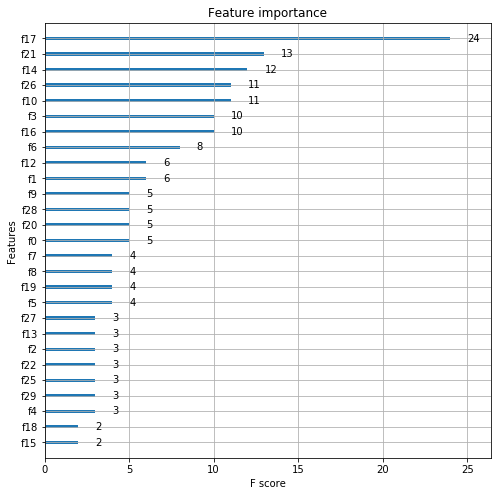

In [0]:
# Feature importance plot
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

[-0.01, 1, 0, 1]

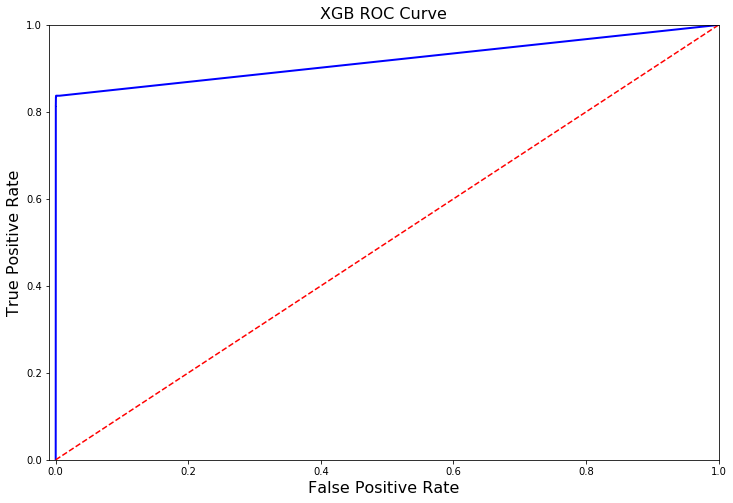

In [0]:
## ROC plot for XGB
xgb_fpr, xgb_tpr, xgb_thresold = roc_curve(y_train, xg_reg.predict(X_train))

plt.figure(figsize=(12,8))
plt.title('XGB ROC Curve', fontsize=16)
plt.plot(xgb_fpr, xgb_tpr, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])

Without any model tunning, both adaboost and xgboost a model we would want. Xgboost model just gave a model with very high precision in both classes and xgboost model also trains very fast. Considering about all the time and efforts we needed in the data preparation work for sampling techniques, the bagging techniques like boosting machines could be a really effective way for us to solve imbalanced dataset classification task.

## Neural Networks

We could use neural networks to help us with the classification. Here I would only construct a very simple NN model for the classification and an Autoencoder model. The autoencoder model 
would also compress the information in to a lower dimensional space. We could see if we can have a better seperation of the two classes at there.

In [0]:
## Package Loading
from keras import layers
from keras import models
from keras import Model

In [84]:
dense_nn = models.Sequential()
dense_nn.add(layers.Dense(128, activation='relu',input_shape=(X_train.shape[1],)))
dense_nn.add(layers.Dense(128, activation='relu'))
dense_nn.add(layers.Dense(128, activation='relu'))
dense_nn.add(layers.Dense(2, activation='softmax'))
dense_nn.summary()
dense_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_59 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_60 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 258       
Total params: 37,250
Trainable params: 37,250
Non-trainable params: 0
_________________________________________________________________


In [69]:
dense_nn.fit(X_train, y_train, epochs=15,batch_size=5000)

Epoch 1/15
199364/199364 [==============================] - 2s 9us/step - loss: 0.1039 - acc: 0.9746
Epoch 2/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0272 - acc: 0.9983
Epoch 3/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0268 - acc: 0.9983
Epoch 4/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0260 - acc: 0.9983
Epoch 5/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0251 - acc: 0.9983
Epoch 6/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0147 - acc: 0.9984
Epoch 7/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0043 - acc: 0.9993
Epoch 8/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0034 - acc: 0.9993
Epoch 9/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0031 - acc: 0.9993
Epoch 10/15
199364/199364 [==============================] - 2s 8us/step - loss: 0.0030 - a

In [79]:
# Prediction for the test set
dense_nn_pred = dense_nn.predict(X_test)
dense_nn_preds = np.array([np.where(res == np.max(res))[0][0] for res in dense_nn_pred])

# Model evaluation
print(classification_report(y_test, dense_nn_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.93      0.84      0.88       148

    accuracy                           1.00     85443
   macro avg       0.96      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443



**Autoencoder**

In [83]:
# Model construction
inpt = layers.Input(shape=(X_train.shape[1],))
l1 = layers.Dense(128,activation='relu')(inpt)
l2 = layers.Dense(32,activation='relu')(l1)
l3 = layers.Dense(8,activation='relu')(l2)
encoder = layers.Dense(2,activation='relu')(l3)

l4 = layers.Dense(8,activation='relu')(encoder)
l5 = layers.Dense(32,activation='relu')(l4)
l6 = layers.Dense(32,activation='relu')(l5)
decoder = layers.Dense(2,activation='softmax')(l6)

# Seperate the autoencoder model and the encoder
encoder = Model(inpt,encoder)
auto = Model(inpt,decoder)

# Model summary
auto.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               3968      
_________________________________________________________________
dense_51 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_52 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 18        
_________________________________________________________________
dense_54 (Dense)             (None, 8)                 24        
_________________________________________________________________
dense_55 (Dense)             (None, 32)                288       
__________

In [85]:
auto.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
auto.fit(X_train, y_train, epochs=15,batch_size=5000)

Epoch 1/15
199364/199364 [==============================] - 2s 10us/step - loss: 0.6300 - acc: 0.9159
Epoch 2/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.1704 - acc: 0.9983
Epoch 3/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0071 - acc: 0.9983
Epoch 4/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0051 - acc: 0.9983
Epoch 5/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0045 - acc: 0.9983
Epoch 6/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0042 - acc: 0.9983
Epoch 7/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0039 - acc: 0.9985
Epoch 8/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0037 - acc: 0.9987
Epoch 9/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0035 - acc: 0.9992
Epoch 10/15
199364/199364 [==============================] - 1s 5us/step - loss: 0.0033 - 

In [86]:
# Prediction for the test set
auto_pred = auto.predict(X_test)
auto_preds = np.array([np.where(res == np.max(res))[0][0] for res in auto_pred])

# Model evaluation
print(classification_report(y_test, auto_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.86      0.87       148

    accuracy                           1.00     85443
   macro avg       0.94      0.93      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Text(0.5, 1.0, 'Autoencoder Latent Layer Visualization')

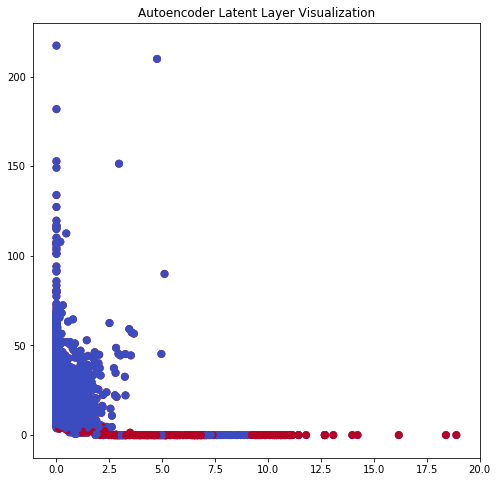

In [92]:
#Autoencoder Latent Layer Visualization
latent_pred = encoder.predict(X_train)
plt.scatter(latent_pred[:,0], latent_pred[:,1], c=(y_train == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(latent_pred[:,0], latent_pred[:,1], c=(y_train == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('Autoencoder Latent Layer Visualization')